0. есть датафрейм df, колонки "title" - название статьи, "annotation" - аннотация, "text" - текст статьи, "authors" - авторы
1. Векторизация текстов с учётом семантических особенностей
2. Кластеризация (нужны небольшие кластеры)
3. Тестирование: выводим статью, смотрим на те же, что в кластере.

SentenceTransformer - работает с предложениями

In [109]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [368]:
#метрики для оценки качества кластеризации без размеченных данных
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [372]:
df = pd.read_excel('date_it_lemm.xlsx')

In [374]:
tqdm.pandas() #применяем прогресс-бар для пандаса

### 1. SentenceTransformer

In [377]:
model = SentenceTransformer('all-MiniLM-L6-v2') #предобученная модель

df['text_embedding'] = df['text'].progress_apply(lambda x: model.encode(x)) #векторизация

100%|██████████| 2308/2308 [01:50<00:00, 20.88it/s]


In [379]:
embeddings = np.array(df['text_embedding'].tolist()) #эмбеддинги в массив

#### 1.1 Agglomerative clustering

In [382]:
n_clusters = len(df) // 8 #будем стремиться к 8 статьям в одном кластере, примерно прикинем сколько это кластеров
print(f"Количество кластеров: {n_clusters}")

#можно брать от 250 до 300
#интересует сколько одиночных статей и метрики

Количество кластеров: 288


In [384]:
clustering = AgglomerativeClustering(n_clusters=n_clusters,linkage='average')
df['cluster'] = clustering.fit_predict(embeddings)

In [414]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes

cluster
124    281
55     189
2      129
20     117
11      76
      ... 
207      1
164      1
257      1
167      1
204      1
Name: count, Length: 288, dtype: int64

In [427]:
embeddings

array([[ 0.02035586,  0.0152269 , -0.0301107 , ..., -0.037193  ,
         0.00285766, -0.00076944],
       [-0.01173243,  0.00454604, -0.05483148, ..., -0.00824263,
        -0.01161202, -0.0139706 ],
       [ 0.02740764,  0.03445563, -0.02333879, ..., -0.00840321,
        -0.01852841, -0.03747246],
       ...,
       [-0.03708796, -0.03273047, -0.00287738, ..., -0.02130094,
        -0.02807206, -0.02130206],
       [-0.00610556, -0.04040697, -0.03221591, ..., -0.00454534,
        -0.02189322, -0.020794  ],
       [ 0.01471194,  0.01128578, -0.04784755, ..., -0.01248087,
        -0.05580978, -0.02022359]], dtype=float32)

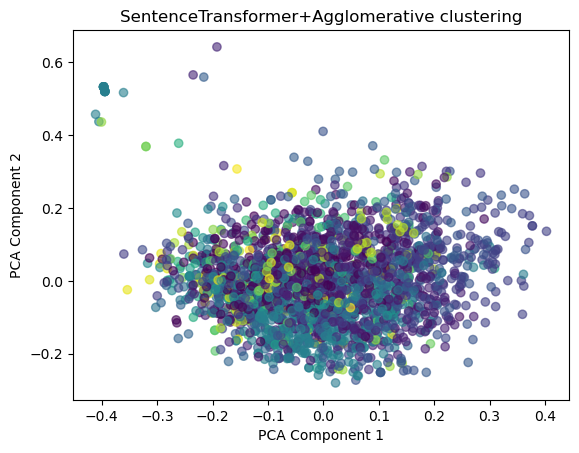

In [435]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure()
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SentenceTransformer+Agglomerative clustering')

plt.show()

На картинке даже два кластера не выделяется. 

In [412]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:100]}...") 
        print("-" * 80)

show_cluster_articles(42)

Title: Программа Blender как основная среда 3D моделирования для разработки игр в unity
Authors: Абляев М. Р., Аметов Ф. Р., Мевлют И. Ш., Адильшаева Э. И.
Annotation: В работе описаны основные возможности программного продукта, главные компоненты пользовательского интерфейса и функциональное назначения каждого из них. Также приведено описание функционала программы и поддерживаемых форматов для экспортирования конечного файла.
Text: технический наука абляй м р студент гр гбоувый рк крымский инженерный педагогический университет аме...
--------------------------------------------------------------------------------
Title: Моделирование игровой сцены при разработке компьютерной игры на платформе Unity 3D
Authors: Аметов Ф. Р., Мевлют И. Ш., Ворожейкин Р. В., Адильшаева Э. И.
Annotation: В работе подчеркивается актуальность моделирования качественной игровой сцены. Описана проблема моделирования игровой сцены. Поэтапно рассмотрен процесс моделирования. В том числе описан процесс добавлени

По-моему, статьи никак не связаны.

In [200]:
import random

random_index = random.randint(0, len(df) - 1) #случайно статью выберем
random_article = df.iloc[random_index]

print(f"Title: {random_article['title']}")
print(f"Authors: {random_article['authors']}")
print(f"Annotation: {random_article['annotation']}")
print(f"Text: {random_article['text'][:500]}...")  # Выводим первые 500 символов текста

cluster_id = random_article['cluster'] #статьи из того же кластера
cluster_articles = df[df['cluster'] == cluster_id]

print("\nСтатьи из того же кластера:")
for _, article in cluster_articles.iterrows():
    print(f"Title: {article['title']}, Authors: {article['authors']}")

Title: Сппр для выбора элементного базиса корпоративных интегрированных информационных систем
Authors: Лисецкий Ю. М.
Annotation: Приведена классификация СППР, описаны ее архитектура, структура и их особенности. Разработана СППР для автоматизации и объективизации процесса выбора элементного базиса КИИС. Функциональное наполнение СППР составляют модели, методы и алгоритмы, направленные на повышение эффективности процесса...
Text: ю м лисецкий сппр выбор элементный базис корпоративный интегрировать информационный система дп эс энд ти украина г киев украина анотацть навести класифгкацгть сппр описать архитектура структура особливостг розробить сппр автоматизаци ектив зацп процес вибора елементный базис функщональня наповненний сппр складаеться з модель метод алгоритм спрямований тдвищенний процес побудовить ключ слово сппр структура модула корпоративный ттегровать тформацтный система елементний базис аннотация привести кла...

Статьи из того же кластера:
Title: Информационное пространство

Здесь можно предположить, что некоторые статьи связаны с КИС, но в остальном разброс большой.

In [298]:
import random

random_index = random.randint(0, len(df) - 1) #случайно статью выберем
random_article = df.iloc[random_index]

print(f"Title: {random_article['title']}")
print(f"Authors: {random_article['authors']}")
print(f"Annotation: {random_article['annotation']}")
print(f"Text: {random_article['text'][:500]}...") 

cluster_id = random_article['cluster'] #статьи из того же кластера
cluster_articles = df[df['cluster'] == cluster_id]

print("\nСтатьи из того же кластера:")
for _, article in cluster_articles.iterrows():
    print(f"Title: {article['title']}, Authors: {article['authors']}")

Title: Оценка работы ледокольного флота в Волго-Каспийском морском судоходном канале
Authors: Темникова Алена Александровна
Annotation: В последние годы ледоколы не справляются с нагрузкой в Волго-Каспийском морском судоходном канале в тяжелых ледовых условиях. С помощью теории массового обслуживания (теории очередей) можно определить рациональность введения дополнительных судов в ледокольный флот, что помогло бы изменить ситуацию...
Text: темников оценка работа ледокольный флот волго каспийский морской судоходный канал последний год ледокол справляться нагрузка волго каспийский морской судоходный канал тяжёлый ледовый условие помощь теория массовый обслуживание теория очередь определить рациональность введение дополнительный судно ледокольный флот помочь изменить ситуация проводка караван судно волго каспийский морской судоходный канал ледокольный флот рассматриваться обслуживающий система каждый запрос проводка караван судно вып...

Статьи из того же кластера:
Title: Модель оценки вр

Можно отметить, что все статьи в кластере так или иначе связаны со временем.

In [419]:
print("Silhouette Score:", silhouette_score(X, df['cluster'])) # (чем ближе к 1, тем лучше)
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, df['cluster'])) #чем выше значение, тем лучше
print("Davies-Bouldin Index:", davies_bouldin_score(X, df['cluster'])) #чем выше значение, тем лучше

Silhouette Score: -0.402419
Calinski-Harabasz Index: 4.110808707426661
Davies-Bouldin Index: 4.037108677787272


Если оценивать субъективно, попаданий, скорее, нет. Попробуем прогнать через цикл и посмотреть результат с разным количеством кластеров.

In [622]:
#пробую автоматизированно прогнать в цикле и получить метрики для разного количества кластеров

max_clust_list = []
min_clust_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(50, 350, 10) 

for n_clusters in n_clusters_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    df['cluster'] = clustering.fit_predict(embeddings)
    
    cluster_sizes = df['cluster'].value_counts()
    
    max_clust_list.append(cluster_sizes.max())  
    min_clust_list.append(cluster_sizes[cluster_sizes.isin([1, 2])].count())  
    Silhouett.append(silhouette_score(embeddings, df['cluster']))  
    Calinski_Harabas.append(calinski_harabasz_score(embeddings, df['cluster']))  
    Davies_Bouldin.append(davies_bouldin_score(embeddings, df['cluster'])) 

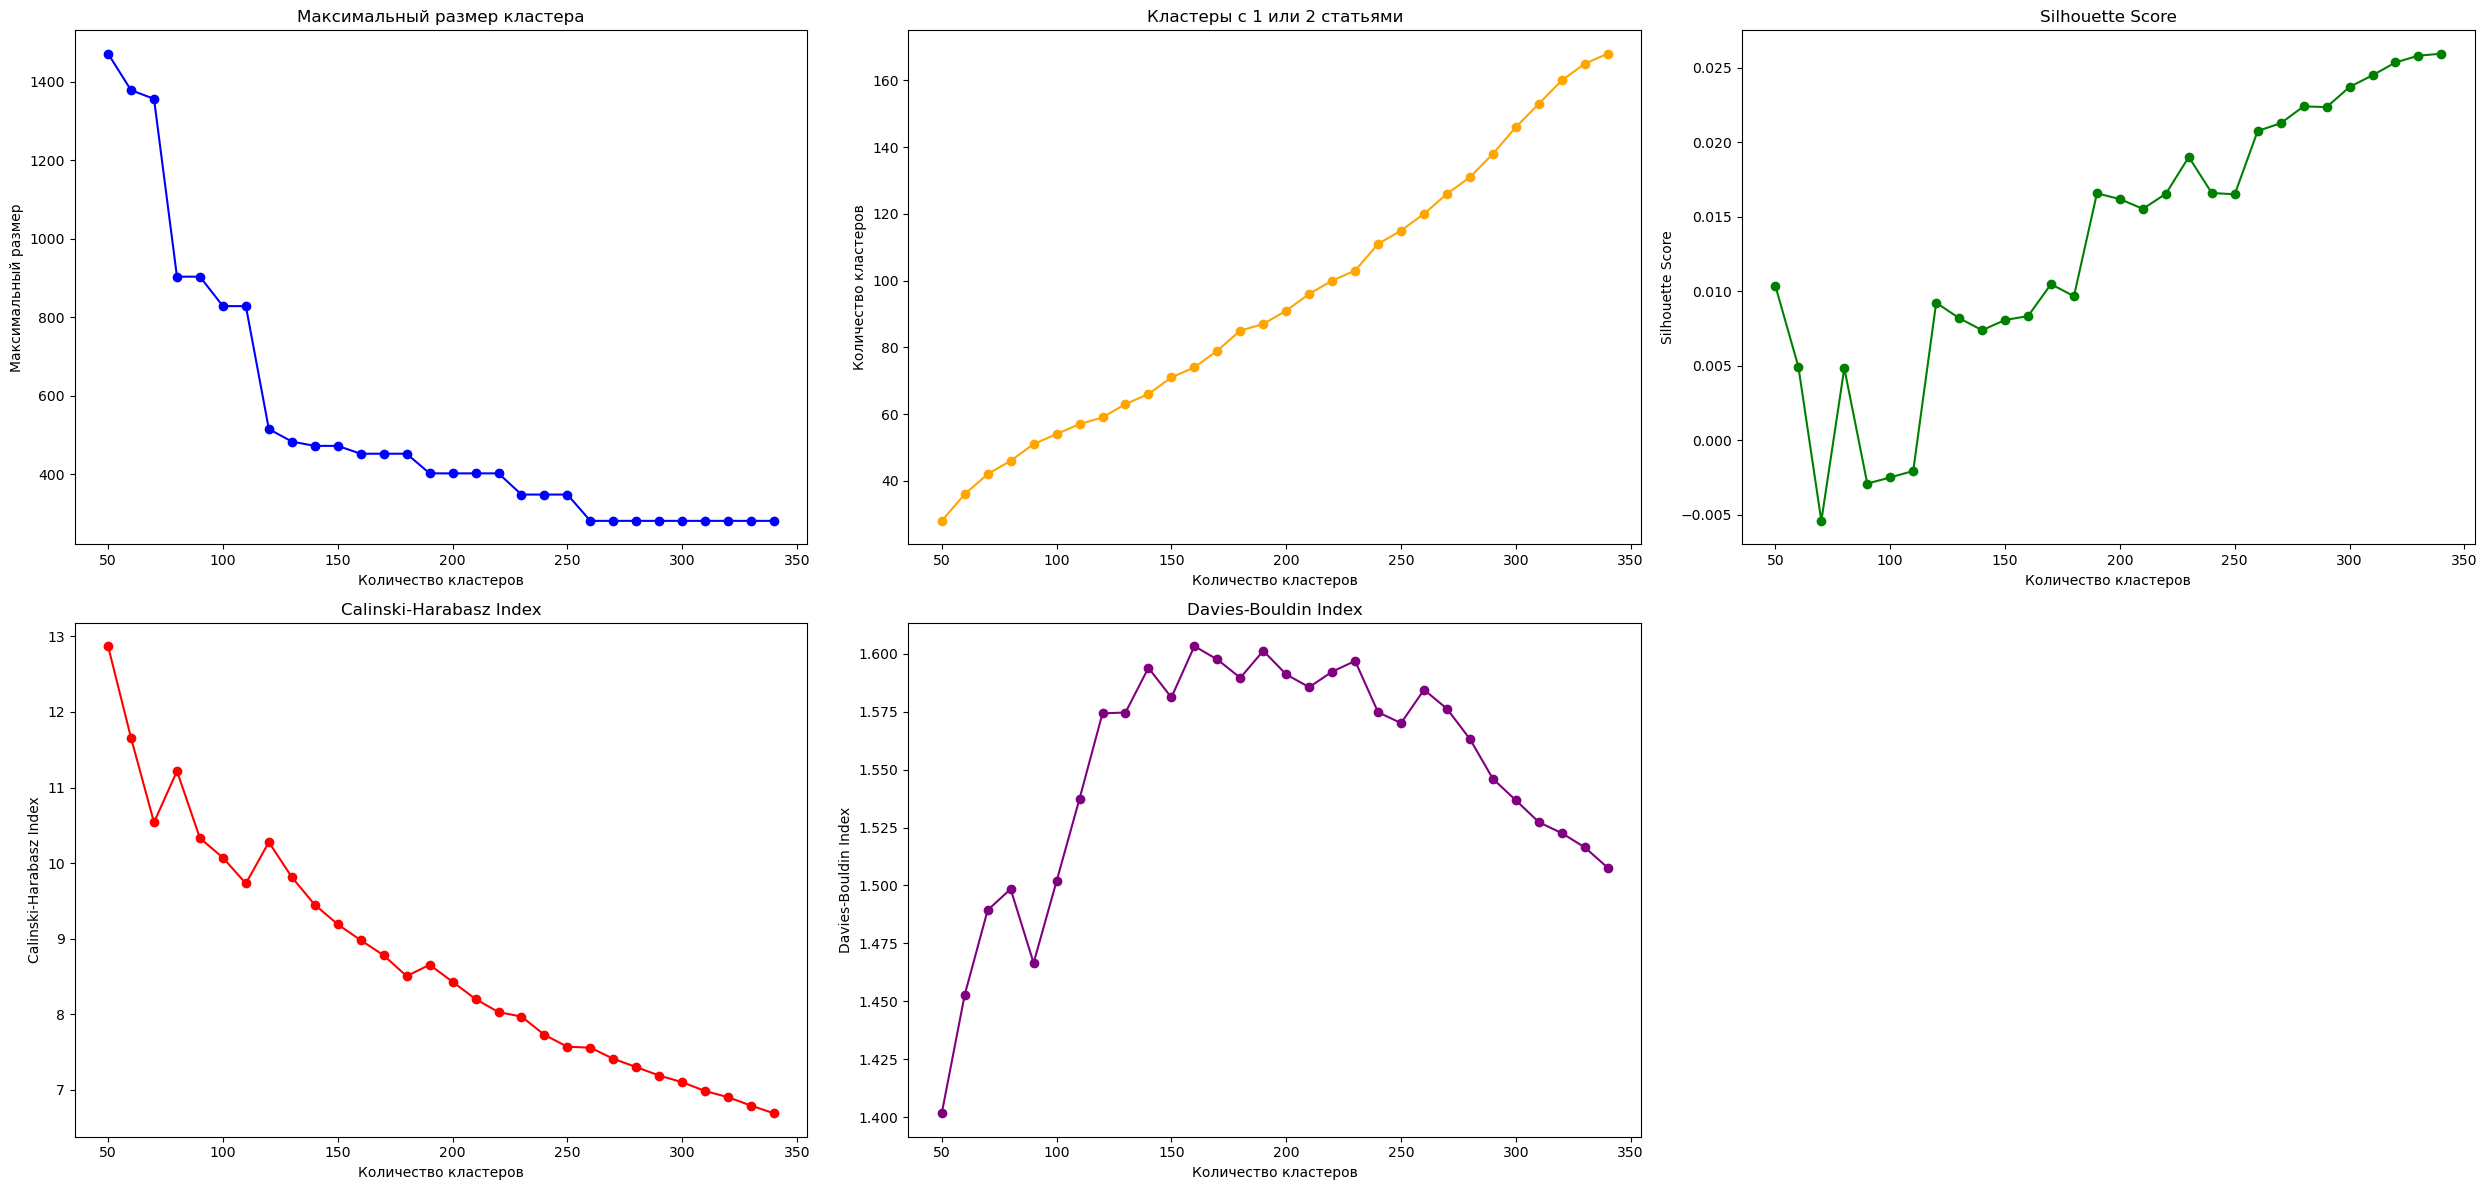

In [661]:
plt.figure(figsize=(25, 12))  

plt.subplot(2, 3, 1)  
plt.plot(n_clusters_range, max_clust_list, marker='o', color='blue')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 2)  
plt.plot(n_clusters_range, min_clust_list, marker='o', color='orange')
plt.title('Кластеры с 1 или 2 статьями')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4) 
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)  
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

Максимальный размер кластера падает в зависимости от количества кластеров, кластеры с 1 и 2 элементами линейно растут, Silhouette тем выше чем выше количество кластеров, Calinski почти линейно падает, а вот Davies-Bouldin можно заметить интересное: низкие значения до 130 кластеров и снова начинает падать после 260 кластеров. Делаем вывод, что оптимальное количество кластеров для данной модели варьируется от 150 до 250.

#### 1.2 DBSCAN

In [437]:
eps = 0.3 #максимальное расстояние между двумя образцами для того, чтобы они считались соседями
min_samples = 2  #минимальное количество образцов в окрестности точки, чтобы она считалась ядром

clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
df['cluster'] = clustering.fit_predict(embeddings)

cluster_sizes = df['cluster'].value_counts()
print("Размеры кластеров:")
print(cluster_sizes)

if -1 in cluster_sizes:
    print(f"Количество статей, не попавших в кластеры (шум): {cluster_sizes[-1]}")

Размеры кластеров:
cluster
 0     1352
-1      798
 9       17
 22      10
 3        6
       ... 
 24       2
 27       2
 28       2
 29       2
 61       2
Name: count, Length: 63, dtype: int64
Количество статей, не попавших в кластеры (шум): 798


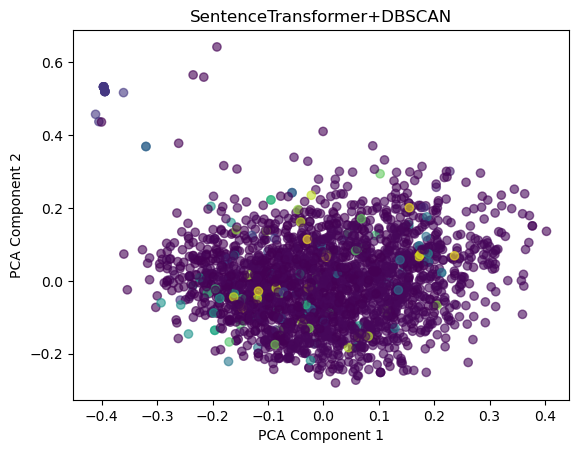

In [441]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure()
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SentenceTransformer+DBSCAN')

plt.show()

In [664]:
#прогоняю в цикле и получаю метрики для разных параметров модели
eps_list = []
min_samples_list = []
n_clusters_list = []
n_noise_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

eps_range = np.linspace(0.1, 1.0, 10)  
min_samples_range = range(2, 11)  


for eps in eps_range:
    for min_samples in min_samples_range:
        
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        df['cluster'] = clustering.fit_predict(embeddings)
        
        n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
    
        n_noise = list(df['cluster']).count(-1) #количество шума
        
        eps_list.append(eps)
        min_samples_list.append(min_samples)
        n_clusters_list.append(n_clusters)
        n_noise_list.append(n_noise)
        
        if n_clusters > 1:
            Silhouett.append(silhouette_score(embeddings, df['cluster']))
            Calinski_Harabas.append(calinski_harabasz_score(embeddings, df['cluster']))
            Davies_Bouldin.append(davies_bouldin_score(embeddings, df['cluster']))
        else:
            Silhouett.append(np.nan) 
            Calinski_Harabas.append(np.nan)
            Davies_Bouldin.append(np.nan)

In [666]:
eps_list = np.array(eps_list)
min_samples_list = np.array(min_samples_list)
n_clusters_list = np.array(n_clusters_list)
n_noise_list = np.array(n_noise_list)
Silhouett = np.array(Silhouett)
Calinski_Harabas = np.array(Calinski_Harabas)
Davies_Bouldin = np.array(Davies_Bouldin)

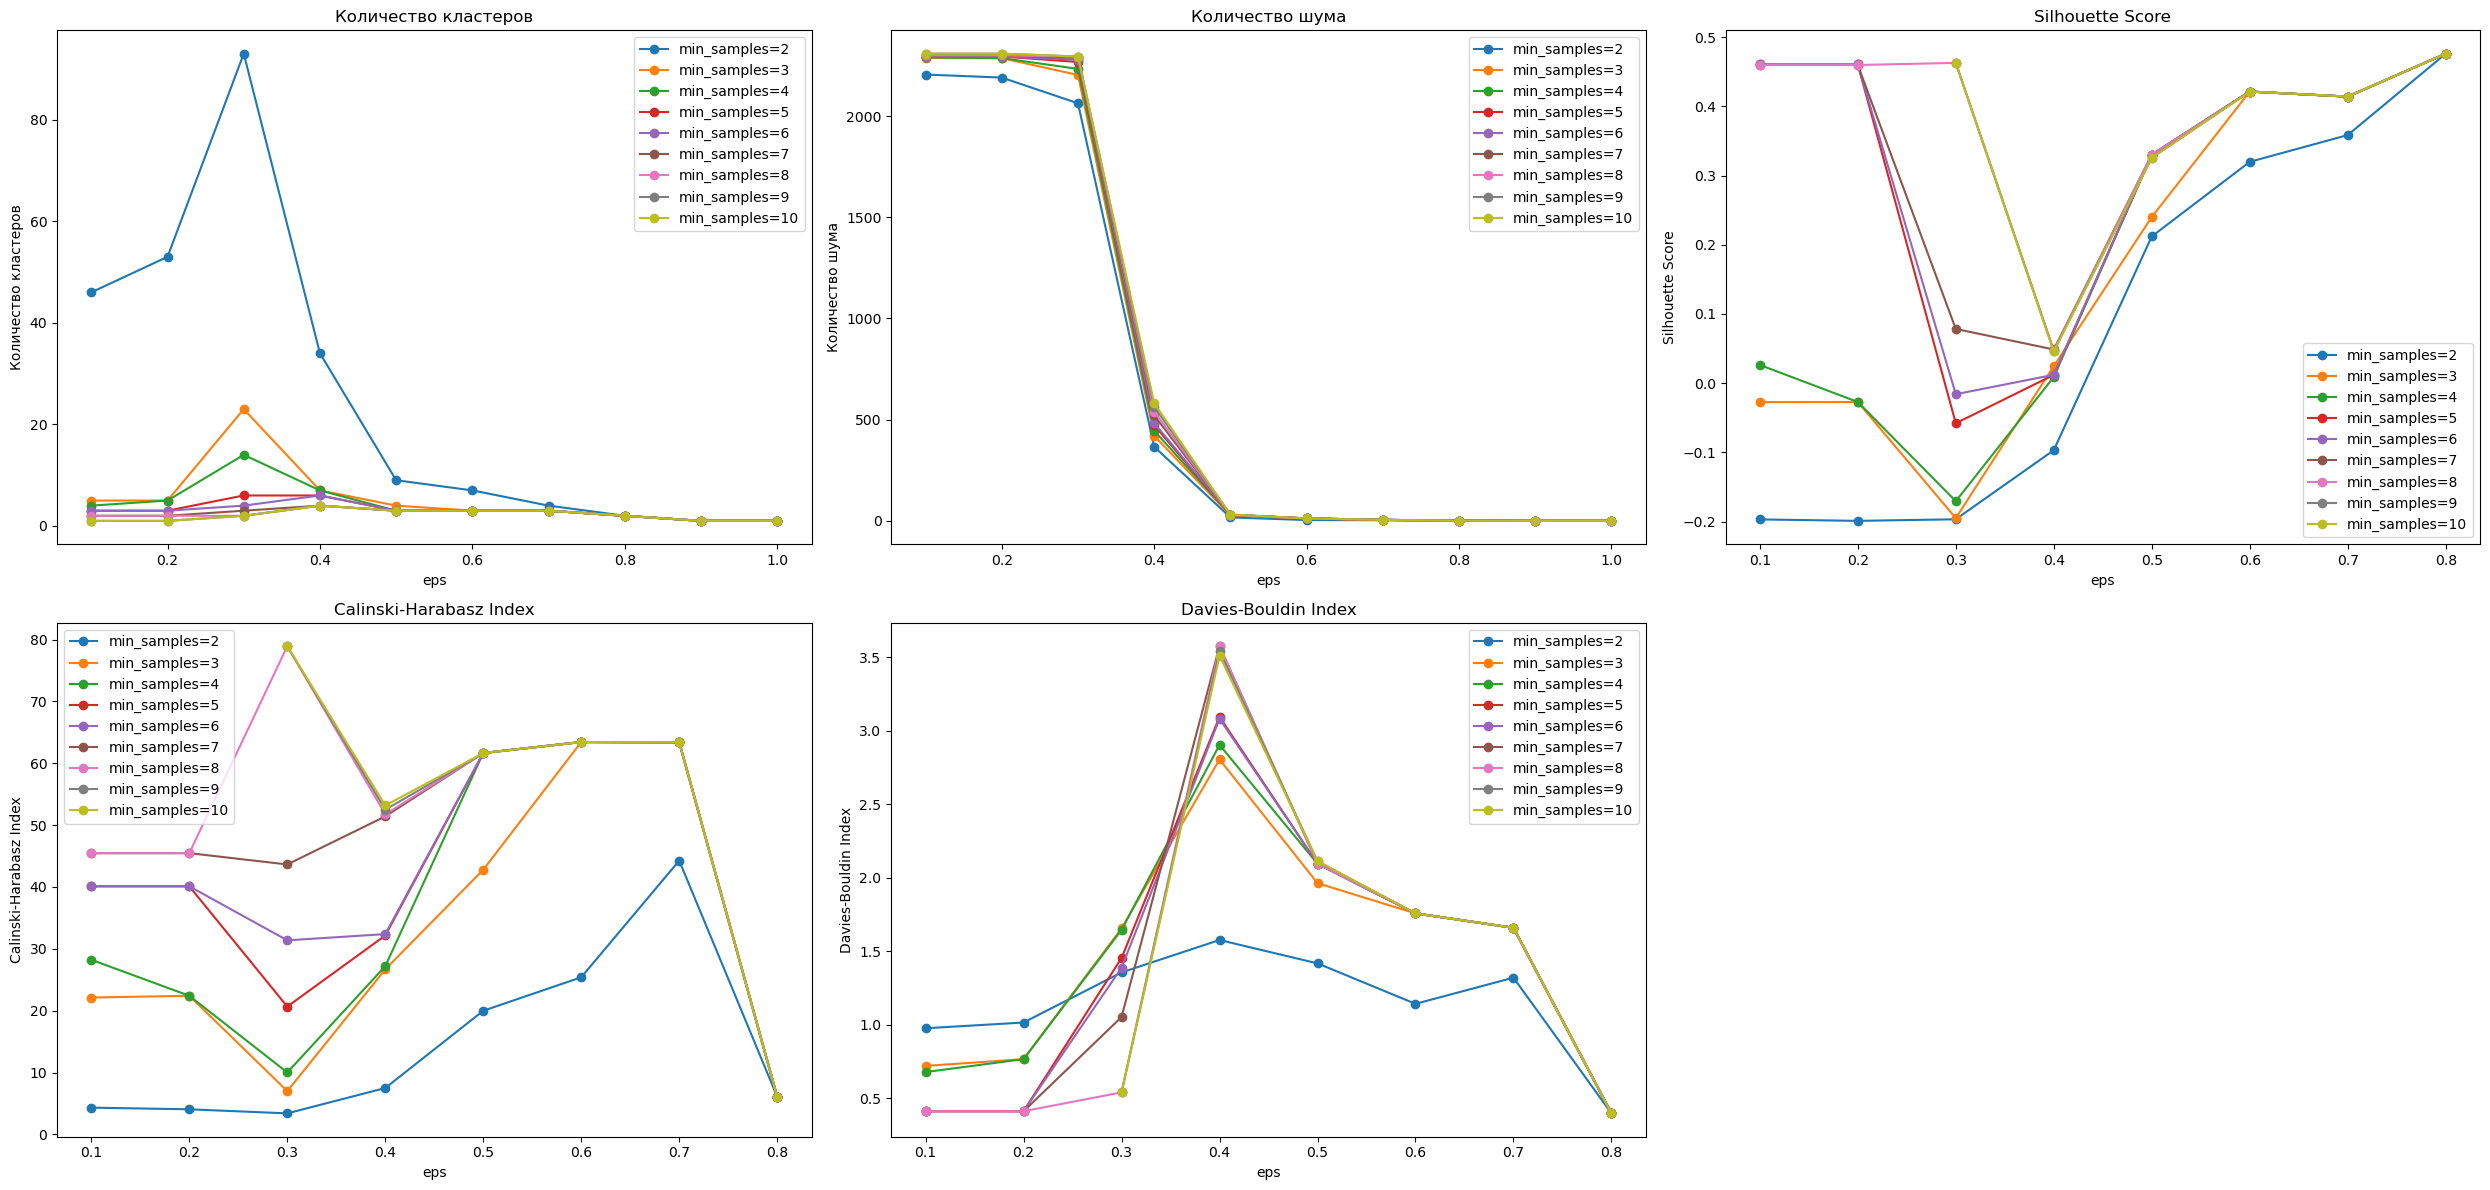

In [670]:
plt.figure(figsize=(25, 12))  

plt.subplot(2, 3, 1)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], n_clusters_list[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Количество кластеров')
plt.xlabel('eps')
plt.ylabel('Количество кластеров')
plt.legend()

plt.subplot(2, 3, 2) 
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], n_noise_list[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Количество шума')
plt.xlabel('eps')
plt.ylabel('Количество шума')
plt.legend()

plt.subplot(2, 3, 3)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], Silhouett[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Silhouette Score')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.legend()

plt.subplot(2, 3, 4)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], Calinski_Harabas[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Calinski-Harabasz Index')
plt.xlabel('eps')
plt.ylabel('Calinski-Harabasz Index')
plt.legend()

plt.subplot(2, 3, 5)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], Davies_Bouldin[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Davies-Bouldin Index')
plt.xlabel('eps')
plt.ylabel('Davies-Bouldin Index')
plt.legend()

plt.tight_layout()
plt.show()

В DBSCAN как ни крути параметры, всё равно либо очень много шума, либо очень много статей в одном кластере. В плане сглаженности размеров кластеров аггломеративная лучше была.

#### 1.3 K-means

In [455]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

cluster_sizes = df['cluster'].value_counts()
print("Размеры кластеров:")
print(cluster_sizes[90:110])

cluster_sizes = df['cluster'].value_counts()

single_item_clusters = (cluster_sizes == 1).sum()

print(f"Количество кластеров с ровно 1 элементом: {single_item_clusters}")

Размеры кластеров:
cluster
158    10
39     10
176    10
111    10
19     10
8      10
25     10
102    10
29     10
252    10
174     9
232     9
11      9
248     9
2       9
181     9
32      9
239     9
14      9
142     9
Name: count, dtype: int64
Количество кластеров с ровно 1 элементом: 20


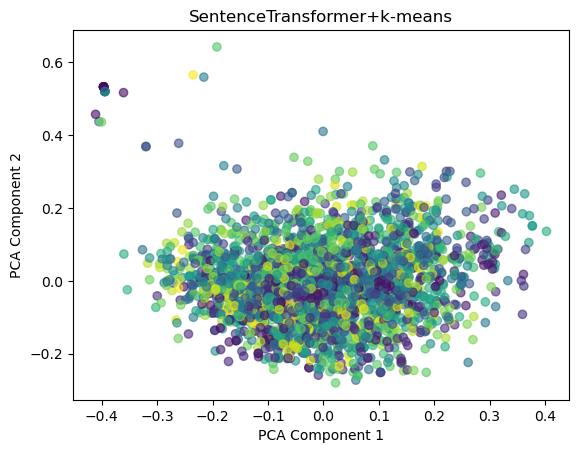

In [447]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure()
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SentenceTransformer+k-means')

plt.show()

In [457]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:100]}...") 
        print("-" * 80)

show_cluster_articles(2)

Title: ПОСТРОЕНИЕ ИНСТРУМЕНТАЛЬНОЙ МОДЕЛИ ДЛЯ ИССЛЕДОВАНИЯ СИСТЕМЫ "КОМПЬЮТЕРНЫЙ ВИРУС-ПЕРЕНОСЧИК-АВТОМАТИЗИРОВАННОЕ РАБОЧЕЕ МЕСТО-ЛОКАЛЬНАЯ ВЫЧИСЛИТЕЛЬНАЯ СЕТЬ"
Authors: Горячев С. Н., Кобяков Н. С., Костарев С. Н.
Annotation: Рассмотрен механизм заражения компьютерными вирусами автоматизированных рабочих мест, передача вируса от зараженного автоматизированного рабочего места к незараженному. Проанализировано воздействие компьютерного вируса на локально-вычислительную сеть. Представлена инструментальная модель для...
Text: вестник пермский университет математик механика информатика вып построение инструментальный модель и...
--------------------------------------------------------------------------------
Title: Обзор SCADA-системы genesis64
Authors: Набокин И., Ковалева В. В.
Annotation: no annotation
Text: обзор тема набокина магистр гр дцау маг м ковалёв н доцент кафедра апп настоящий время оставаться ко...
----------------------------------------------------------------------------

Есть попадание, все статьи так или иначе связаны с обучением людей.

In [460]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:100]}...") 
        print("-" * 80)

show_cluster_articles(32)

Title: СИСТЕМНО-ОБЪЕКТНЫЙ ПОДХОД К СИСТЕМНОМУ АНАЛИЗУ: ОСОБЕННОСТИ И ПРЕИМУЩЕСТВА
Authors: Михелёв Владимир Владимирович
Annotation: В статье рассматриваются особенности системно-объектного детерминантного анализа (СОДА), представляющего собой результат применения системно-объектного подхода «Узел-Функция-Объект» к детерминантному подходу Г.П. Мельникова. Обоснованы преимущества СОДА по сравнению с существующими методами...
Text: системный анализ управление системно объектный подход системный анализ особенность преимущество михе...
--------------------------------------------------------------------------------
Title: О выборе закона распределения продолжительности передачи пакетированных данных в корпоративных компьютерных сетях
Authors: Иевлев Евгений Сергеевич
Annotation: В связи со стремительным развитием компьютерных технологий одной из наиболее актуальных становится задача разработки моделей управления сетевыми процессами. Сложность ее решения состоит в том, что сетевые процессы 

Тоже как будто есть попадание, большинство статей связаны с обработкой 3д.

In [464]:
print("Silhouette Score:", silhouette_score(X, df['cluster'])) # (чем ближе к 1, тем лучше)
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, df['cluster'])) #чем выше значение, тем лучше
print("Davies-Bouldin Index:", davies_bouldin_score(X, df['cluster'])) #чем выше значение, тем лучше

Silhouette Score: -0.34391195
Calinski-Harabasz Index: 3.98783306120595
Davies-Bouldin Index: 5.597489393024072


Сказала бы что всё равно субъективно оценила качество кластеризации как плохое, но лучше чем аггломеративная, и метрики тут тоже получше.

In [684]:
n_clusters_list = []
single_item_clusters_list = []
max_cluster_size_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(50, 350, 10)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(embeddings)
    
    cluster_sizes = df['cluster'].value_counts()
    single_item_clusters = (cluster_sizes == 1).sum()
    max_cluster_size = cluster_sizes.max()
    
    n_clusters_list.append(n_clusters)
    single_item_clusters_list.append(single_item_clusters)
    max_cluster_size_list.append(max_cluster_size)
    Silhouett.append(silhouette_score(embeddings, df['cluster']))
    Calinski_Harabas.append(calinski_harabasz_score(embeddings, df['cluster']))
    Davies_Bouldin.append(davies_bouldin_score(embeddings, df['cluster']))

In [ ]:
for i, n_clusters in enumerate(n_clusters_range): #чтоб посмотреть какие значения хорошо получились
    print(f"Количество кластеров: {n_clusters}")
    print(f"  - Кластеров с 1 элементом: {single_item_clusters_list[i]}")
    print(f"  - Silhouette Score: {Silhouett[i]}")
    print(f"  - Calinski-Harabasz Index: {Calinski_Harabas[i]}")
    print(f"  - Davies-Bouldin Index: {Davies_Bouldin[i]}")
    print("-" * 40)

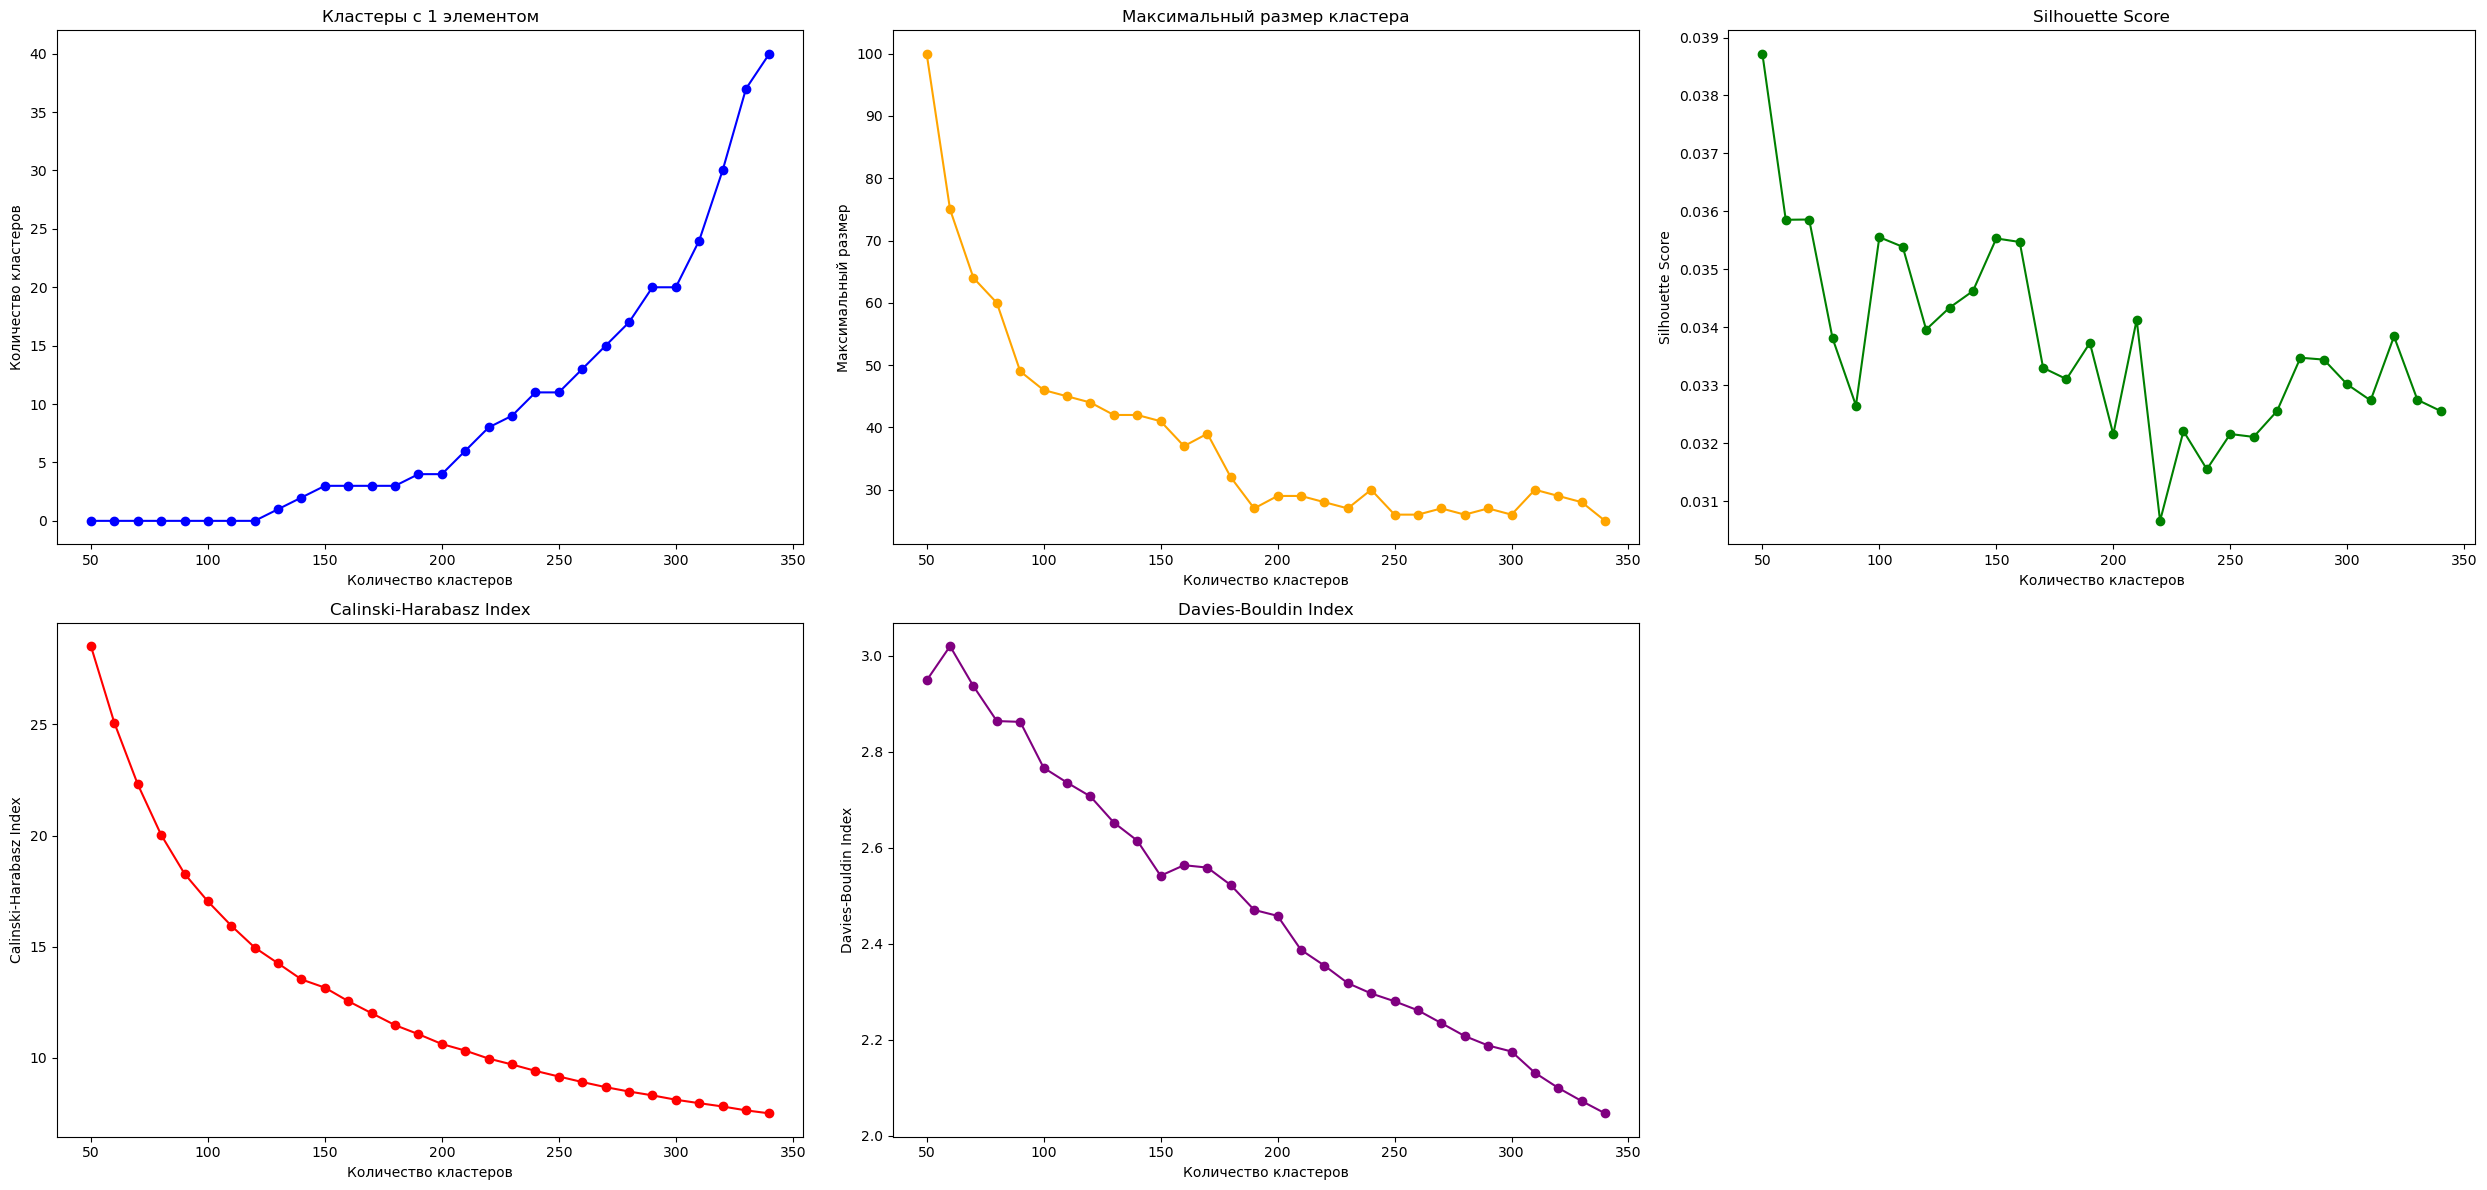

In [704]:
plt.figure(figsize=(25, 12))

plt.subplot(2, 3, 1)
plt.plot(n_clusters_range, single_item_clusters_list, marker='o', color='blue')
plt.title('Кластеры с 1 элементом')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 2)
plt.plot(n_clusters_range, max_cluster_size_list, marker='o', color='orange')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4)
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

Ну по графикам ничего неожиданного, все метрики качество падают с увеличением количества кластеров, но вот количество кластеров с одним элементов резко вырастает после количества кластеров больше чем 300. Ещё на силуэте можно заметить небольшой скачок между 300 и 350, это количество кластеров = 320. Но остальные метрики всё равно линейно падают.

### 2. TF-IDF

Смысл текста не сохраняет модель, но попробую.

In [467]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [469]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])

In [471]:
X_dense = X.toarray() #для агломеративной преобразуем разреженную матрицу в плотную

In [473]:
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
df['cluster'] = agglo.fit_predict(X_dense)

In [ ]:
linked = linkage(X_dense, method='average', metric='cosine') #имеет смысл только на маленьком кусочке данных строить
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индексы статей')
plt.ylabel('Расстояние')
plt.show()

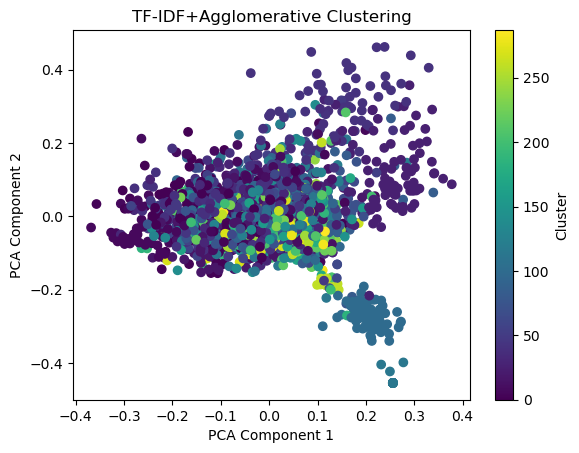

In [475]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.title('TF-IDF+Agglomerative Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [479]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes[90:100]

cluster
34     6
44     6
20     6
91     6
71     6
7      6
106    6
96     6
158    6
17     6
Name: count, dtype: int64

In [481]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:100]}...") 
        print("-" * 80)

show_cluster_articles(34)

Title: Разработка автоматизированной системы эксергетического анализа сложных химико-технологических систем
Authors: Я С. Шевинский, Н А. Кисленко, Д А. Бобров
Annotation: no annotation
Text: родионов клушина н торочешник н техника защита окружающий среда м химия израэль ю экология контроль ...
--------------------------------------------------------------------------------
Title: Моделирование процессов плазмохимического травления диэлектрика для формирования оптического рисунка в технологическом цикле изготовления интегральной микросхемы
Authors: Пацан Александр Владимирович, Перов Геннадий Васильевич
Annotation: В статье рассматривается проблема визуализации процессов плазмохимического травления диэлектрика для формирования оптического рисунка в техническом цикле изготовления интегральной микросхемы, рассмотрен способ решения визуализации данного процесса.
Text: моделирование процесс плазмохимический травление диэлектрик формирование оптический рисунок технолог...
------------------

Всё связано с химиками.

In [258]:
import random

random_index = random.randint(0, len(df) - 1) #случайно статью выберем
random_article = df.iloc[random_index]

print(f"Title: {random_article['title']}")
print(f"Authors: {random_article['authors']}")
print(f"Annotation: {random_article['annotation']}")
print(f"Text: {random_article['text'][:500]}...")  # Выводим первые 500 символов текста

cluster_id = random_article['cluster'] #статьи из того же кластера
cluster_articles = df[df['cluster'] == cluster_id]

print("\nСтатьи из того же кластера:")
for _, article in cluster_articles.iterrows():
    print(f"Title: {article['title']}, Authors: {article['authors']}")

Title: НЕЙРОКВАЛИМЕТРИЯ ИНТЕЛЛЕКТУАЛЬНЫХ КОМПЬЮТЕРНЫХ ИГР
Authors: Гибадуллин Артур Амирзянович
Annotation: Статья описывает те подходы к процессу обучения, которые объединяют в себе методы нейронных сетей и модели квалиметрии. Предметом исследования является игровое обучение. Оно происходит в рамках интерактивного действия, которое предусматривает определенный результат. Явным показателем служит...
Text: нейроквалиметрия интеллектуальный компьютерный игра гибадуллин статья описывать подход процесс обучение объединять метод нейронный сеть модель квалиметрия предмет исследование являться игровой обучение оно происходить рамка интерактивный действие предусматривать определённый результат явный показатель служить качество прохождение игра игровой процесс качество основной задача выступать оценка интеллект результат получать общий оценка человек машина объединять единый схема ключевой слово квалитоло...

Статьи из того же кластера:
Title: Алгоритмы распределения ресурсов для защиты информа

In [489]:
print("Silhouette Score:", silhouette_score(X, df['cluster'])) # (чем ближе к 1, тем лучше)
print("Calinski-Harabasz Index:", calinski_harabasz_score(X.toarray(), df['cluster'])) #чем выше значение, тем лучше
print("Davies-Bouldin Index:", davies_bouldin_score(X.toarray(), df['cluster'])) #чем выше значение, тем лучше

Silhouette Score: 0.05885787080907692
Calinski-Harabasz Index: 3.015774636501165
Davies-Bouldin Index: 2.2083898995102116


Использование TF-IDF больше похоже на обычный поиск по теме. Можно использовать для начальной кластеризации при более сложной архитектуре (например, сначала отсеиваем совсем неподходящие статьи разбивая датасет на небольшое количество кластеров векторизацией TF-IDF, затем используем интеллектуальную векторизацию с сохранением смысла слов и ищем внутри кластера более релевантные статьи). Но цель работу всё же не поисковик по теме которую легко можно сформулировать глядя на кластер, а в поиске скрытых связей и "взаимодополняющих" друг друга исследователей.

Метрики хуже векторизации с помощью SentenceTransform. Т.к смысл работы это попробовать сохранить семантику текста, не буду дальше крутить TF-IDF, попробую word2vec.

### 3. Word2vec

In [536]:
from gensim.models import Word2Vec

In [538]:
df['tokens'] = df['text'].apply(lambda x: x.split())

In [540]:
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4) #дообучение модели на текстах

In [541]:
def text_to_vector(tokens, model): #функция для создания векторного представления текста
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [542]:
X = np.array([text_to_vector(tokens, word2vec_model) for tokens in df['tokens']]) #применение функции к каждому тексту

#### AgglomerativeClustering

In [544]:
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
df['cluster'] = agglo.fit_predict(X)

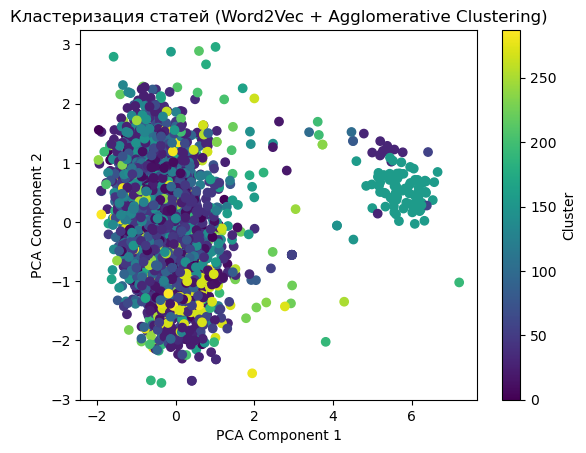

In [545]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Кластеризация статей (Word2Vec + Agglomerative Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [555]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes[80:90]

cluster
53     6
29     6
0      6
2      6
14     6
252    5
93     5
150    5
268    5
137    5
Name: count, dtype: int64

In [567]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:200]}...")  # Выводим первые 200 символов текста
        print("-" * 80)

# Пример: вывод статей из кластера 0
show_cluster_articles(252)

Title: Реализация 3D step модели в среде Autodesk Inventor на примере усилителя мощности на микросхеме ad8367
Authors: Мустафин Ильдар Фаридович
Annotation: При трассировке принципиальных схем зачастую требуется знание о реальных размерах будущей печатной платы с нанесенными на неё компонентами. Это необходимо для того, чтобы, к примеру, проводить презентацию будущего изделия, демонстрируя её 3D модель, а также правильно подобрать готовый корпус или...
Text: реализация модель среда пример усилитель мощность микросхема мустафина ильдар фаридович томский государственный университет система управление радиоэлектроника г томск аннотация трассировка принципиал...
--------------------------------------------------------------------------------
Title: Применение параметрического режима в 2-D моделировании для создания автоматизированной компоновочной схемы станка-качалки
Authors: Острицов Иван Владимирович, Оселедец Виктор Александрович, Кадеров Хайдярь Кадерович, Киреев Сергей Олегович
Annot

Хорошо сохранён смысл статей, при этом данные в одном кластере не похожи на обычный поиск, т.к здесь описано моделирование, но совершенно разными способами. С поиском бы так скорее всего не получилось бы.

In [572]:
print("Silhouette Score:", silhouette_score(X, df['cluster'])) # (чем ближе к 1, тем лучше)
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, df['cluster'])) #чем выше значение, тем лучше
print("Davies-Bouldin Index:", davies_bouldin_score(X, df['cluster'])) #чем выше значение, тем лучше

Silhouette Score: 0.080045514
Calinski-Harabasz Index: 29.215486481152897
Davies-Bouldin Index: 1.2365762583883335


Субъективно оценила бы качество кластеризации как хорошее. Метрика Calinski-Harabasz Index тоже отличная, остальные хуже чем при векторизации SentenceTransform.

In [712]:
n_clusters_list = []
single_item_clusters_list = []
max_cluster_size_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(50, 351, 10)

for n_clusters in n_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    df['cluster'] = agglo.fit_predict(X)
    
    cluster_sizes = df['cluster'].value_counts()
    single_item_clusters = (cluster_sizes == 1).sum()
    max_cluster_size = cluster_sizes.max()
    
    n_clusters_list.append(n_clusters)
    single_item_clusters_list.append(single_item_clusters)
    max_cluster_size_list.append(max_cluster_size)
    Silhouett.append(silhouette_score(X, df['cluster']))
    Calinski_Harabas.append(calinski_harabasz_score(X, df['cluster']))
    Davies_Bouldin.append(davies_bouldin_score(X, df['cluster']))

In [ ]:
for i, n_clusters in enumerate(n_clusters_range):
    print(f"Количество кластеров: {n_clusters}")
    print(f"  - Кластеров с 1 элементом: {single_item_clusters_list[i]}")
    print(f"  - Максимальный размер кластера: {max_cluster_size_list[i]}")
    print(f"  - Silhouette Score: {Silhouett[i]}")
    print(f"  - Calinski-Harabasz Index: {Calinski_Harabas[i]}")
    print(f"  - Davies-Bouldin Index: {Davies_Bouldin[i]}")
    print("-" * 40)

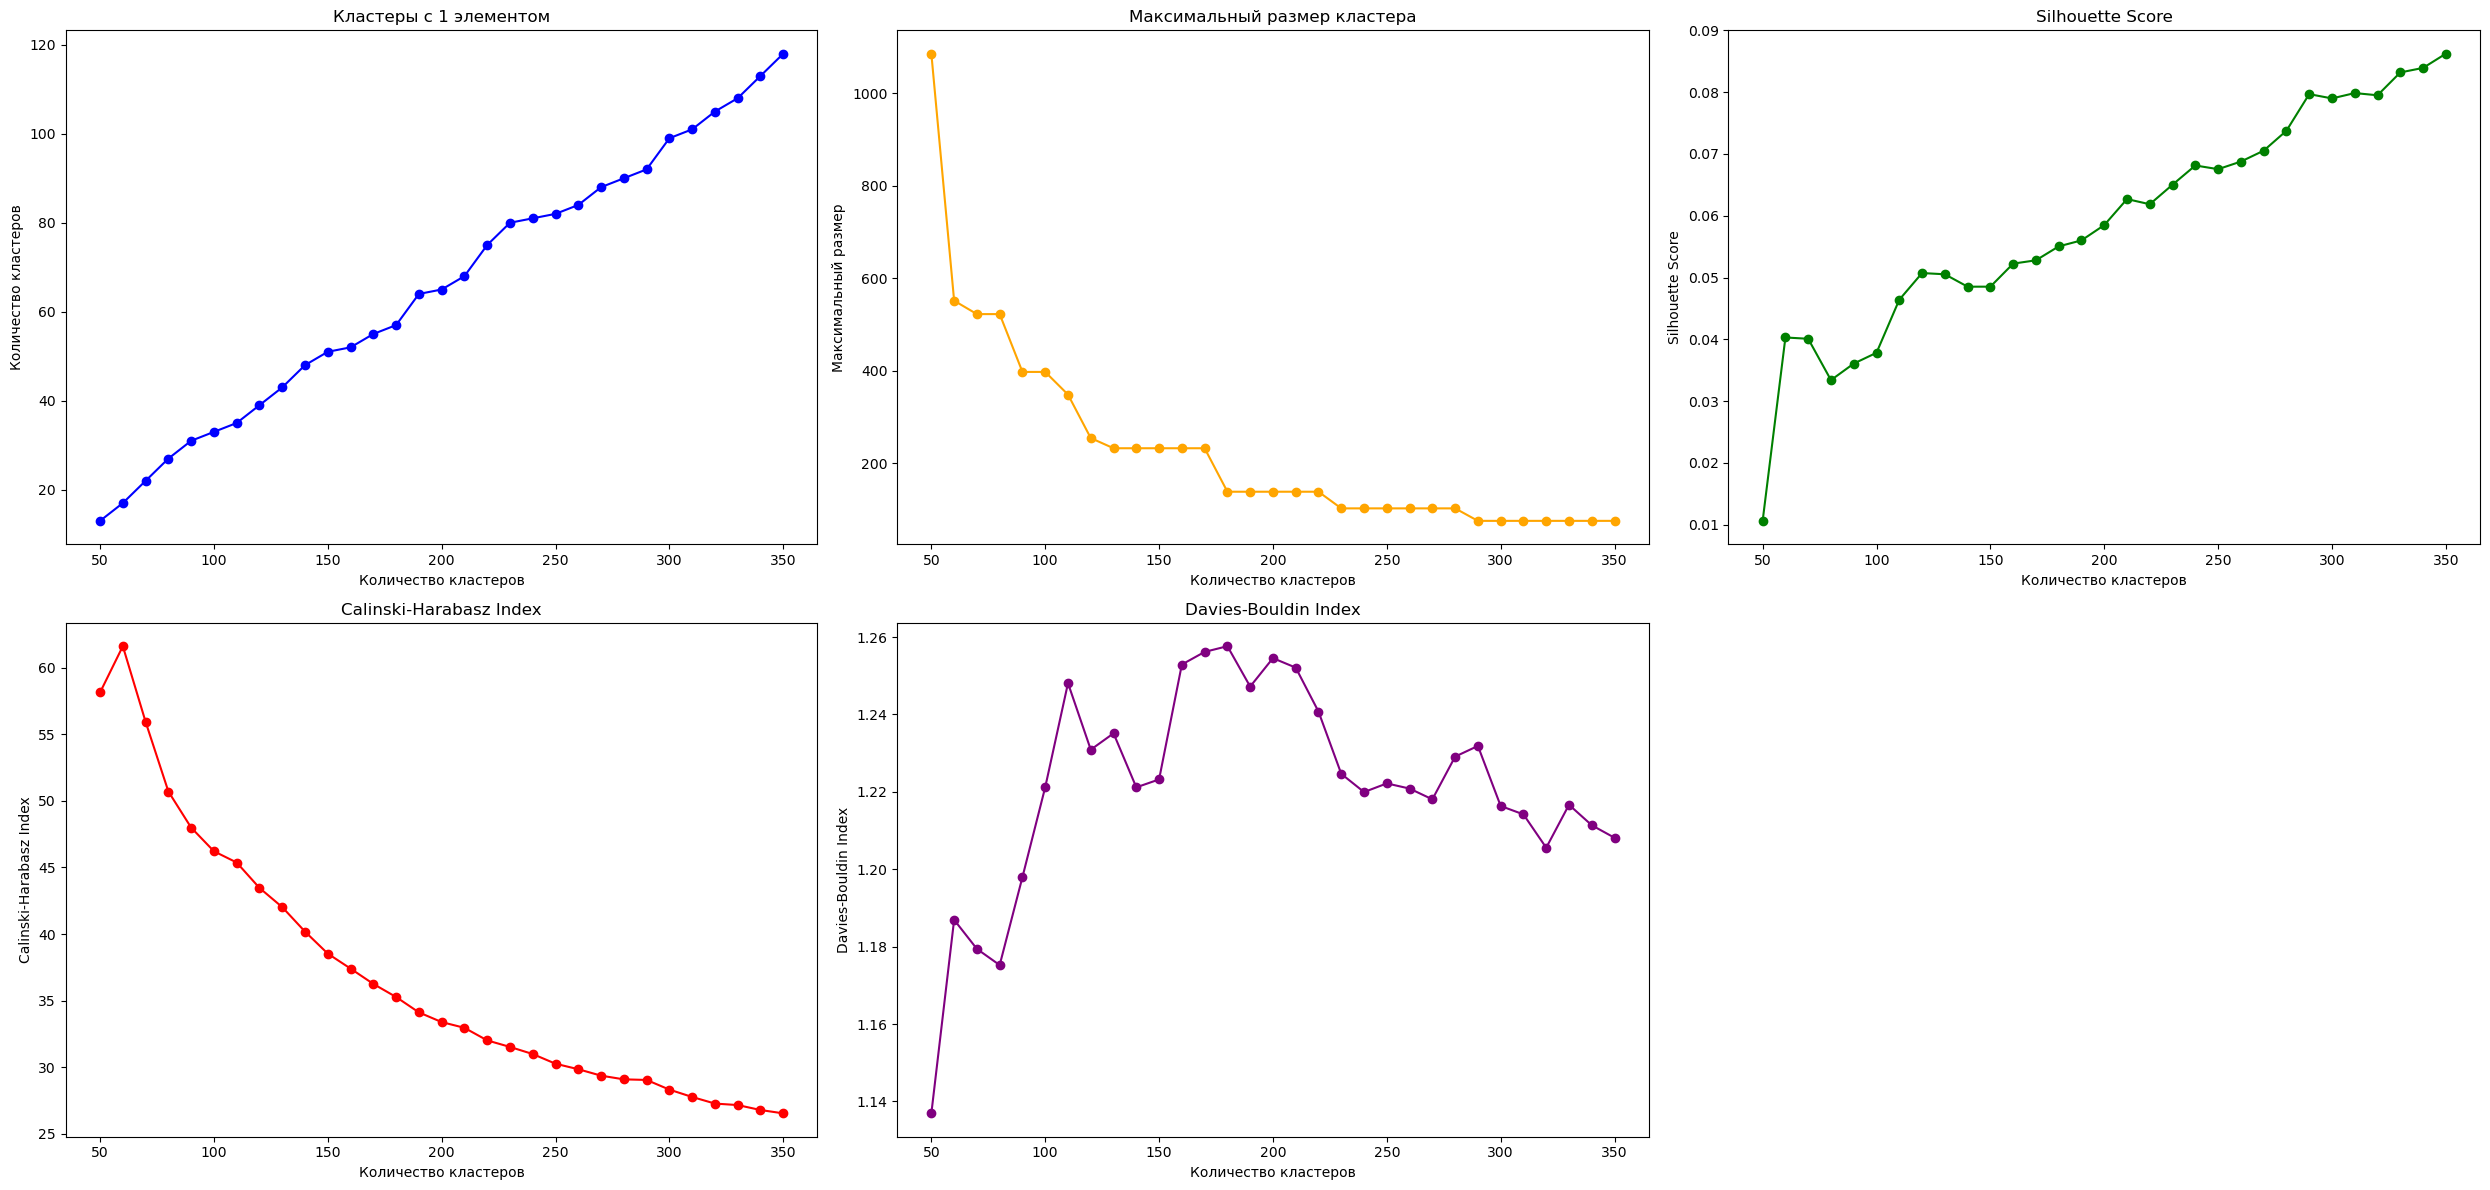

In [722]:
plt.figure(figsize=(25, 12))

plt.subplot(2, 3, 1)
plt.plot(n_clusters_range, single_item_clusters_list, marker='o', color='blue')
plt.title('Кластеры с 1 элементом')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 2)
plt.plot(n_clusters_range, max_cluster_size_list, marker='o', color='orange')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4)
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

Интересные результаты у Davies-Bouldin, при количестве кластеров 290 метрика достаточно высокая. При этом очень противоречивые результаты у силуэта и калински, в то время как одна падает, другая растёт. По количеству кластеров с 1 элементом всё предсказуемо, а вот максимальный размер кластера падает после n=280 и так и остаётся на том же уровне.

#### k-means

In [575]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [577]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes[140:150]

cluster
184    8
208    8
257    8
255    8
112    8
183    7
156    7
188    7
221    7
211    7
Name: count, dtype: int64

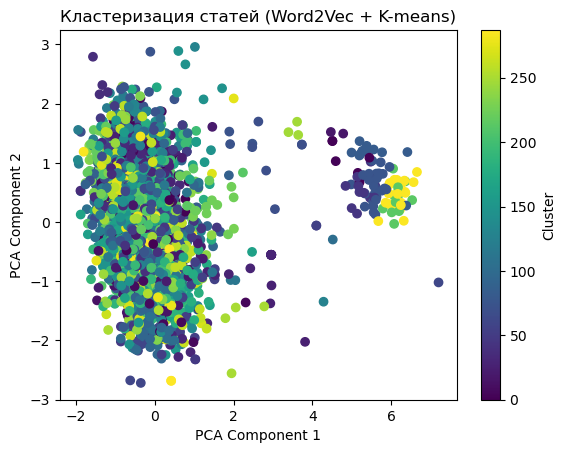

In [579]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Кластеризация статей (Word2Vec + K-means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [581]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:200]}...")  # Выводим первые 200 символов текста
        print("-" * 80)

# Пример: вывод статей из кластера 0
show_cluster_articles(184)

Title: ИСПОЛЬЗОВАНИЕ СИСТЕМ КОМПЬЮТЕРНОЙ АЛГЕБРЫ ДЛЯ ПОВЫШЕНИЯ КАЧЕСТВА ЗНАНИЙ ПРИ ИЗУЧЕНИИ ДИСЦИПЛИНЫ "ЧИСЛЕННЫЕ МЕТОДЫ"
Authors: Шевченко А. С.
Annotation: Актуальность исследуемой проблемы связана со следующими факторами. С одной стороны, внедрение Федеральных образовательных стандартов третьего поколения и соблюдение Болонских соглашений в системе образования России предполагают выделение значительного числа часов на самостоятельное изучение учебных ...
Text: мир наука педагогика психология статья ссылка цитирование статья шевченко использование система компьютерный алгебра повышение качество знание изучение дисциплина численный метод мир наука педагогика ...
--------------------------------------------------------------------------------
Title: ФОРМИРОВАНИЕ ВЫЧИСЛИТЕЛЬНОГО МЫШЛЕНИЯ НА ОСНОВЕ СОСТАВЛЕНИЯ АЛГОРИТМОВ РЕШЕНИЯ ЗАДАЧ
Authors: С О. Алтухова, З А. Кононова
Annotation: В статье поднимается вопрос о необходимости формирования вычислительного мышления в процессе обучения сту

Достаточно хорошо сработано, и даже на поиск похоже ещё меньше, чем с агломеративной кластеризацией, но при этом статьи действительно связаны между собой.

In [584]:
print("Silhouette Score:", silhouette_score(X, df['cluster']))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, df['cluster']))
print("Davies-Bouldin Index:", davies_bouldin_score(X, df['cluster']))

Silhouette Score: 0.08062768
Calinski-Harabasz Index: 33.116379407061
Davies-Bouldin Index: 1.6686295850353907


Субъективно оценила бы качество кластеризации как хорошее, метрики выше чем при агломеративной кластеризации.

In [729]:
n_clusters_list = []
single_item_clusters_list = []
max_cluster_size_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(50, 351, 10)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)
    
    cluster_sizes = df['cluster'].value_counts()
    single_item_clusters = (cluster_sizes == 1).sum()
    max_cluster_size = cluster_sizes.max()
    
    n_clusters_list.append(n_clusters)
    single_item_clusters_list.append(single_item_clusters)
    max_cluster_size_list.append(max_cluster_size)
    Silhouett.append(silhouette_score(X, df['cluster']))
    Calinski_Harabas.append(calinski_harabasz_score(X, df['cluster']))
    Davies_Bouldin.append(davies_bouldin_score(X, df['cluster']))

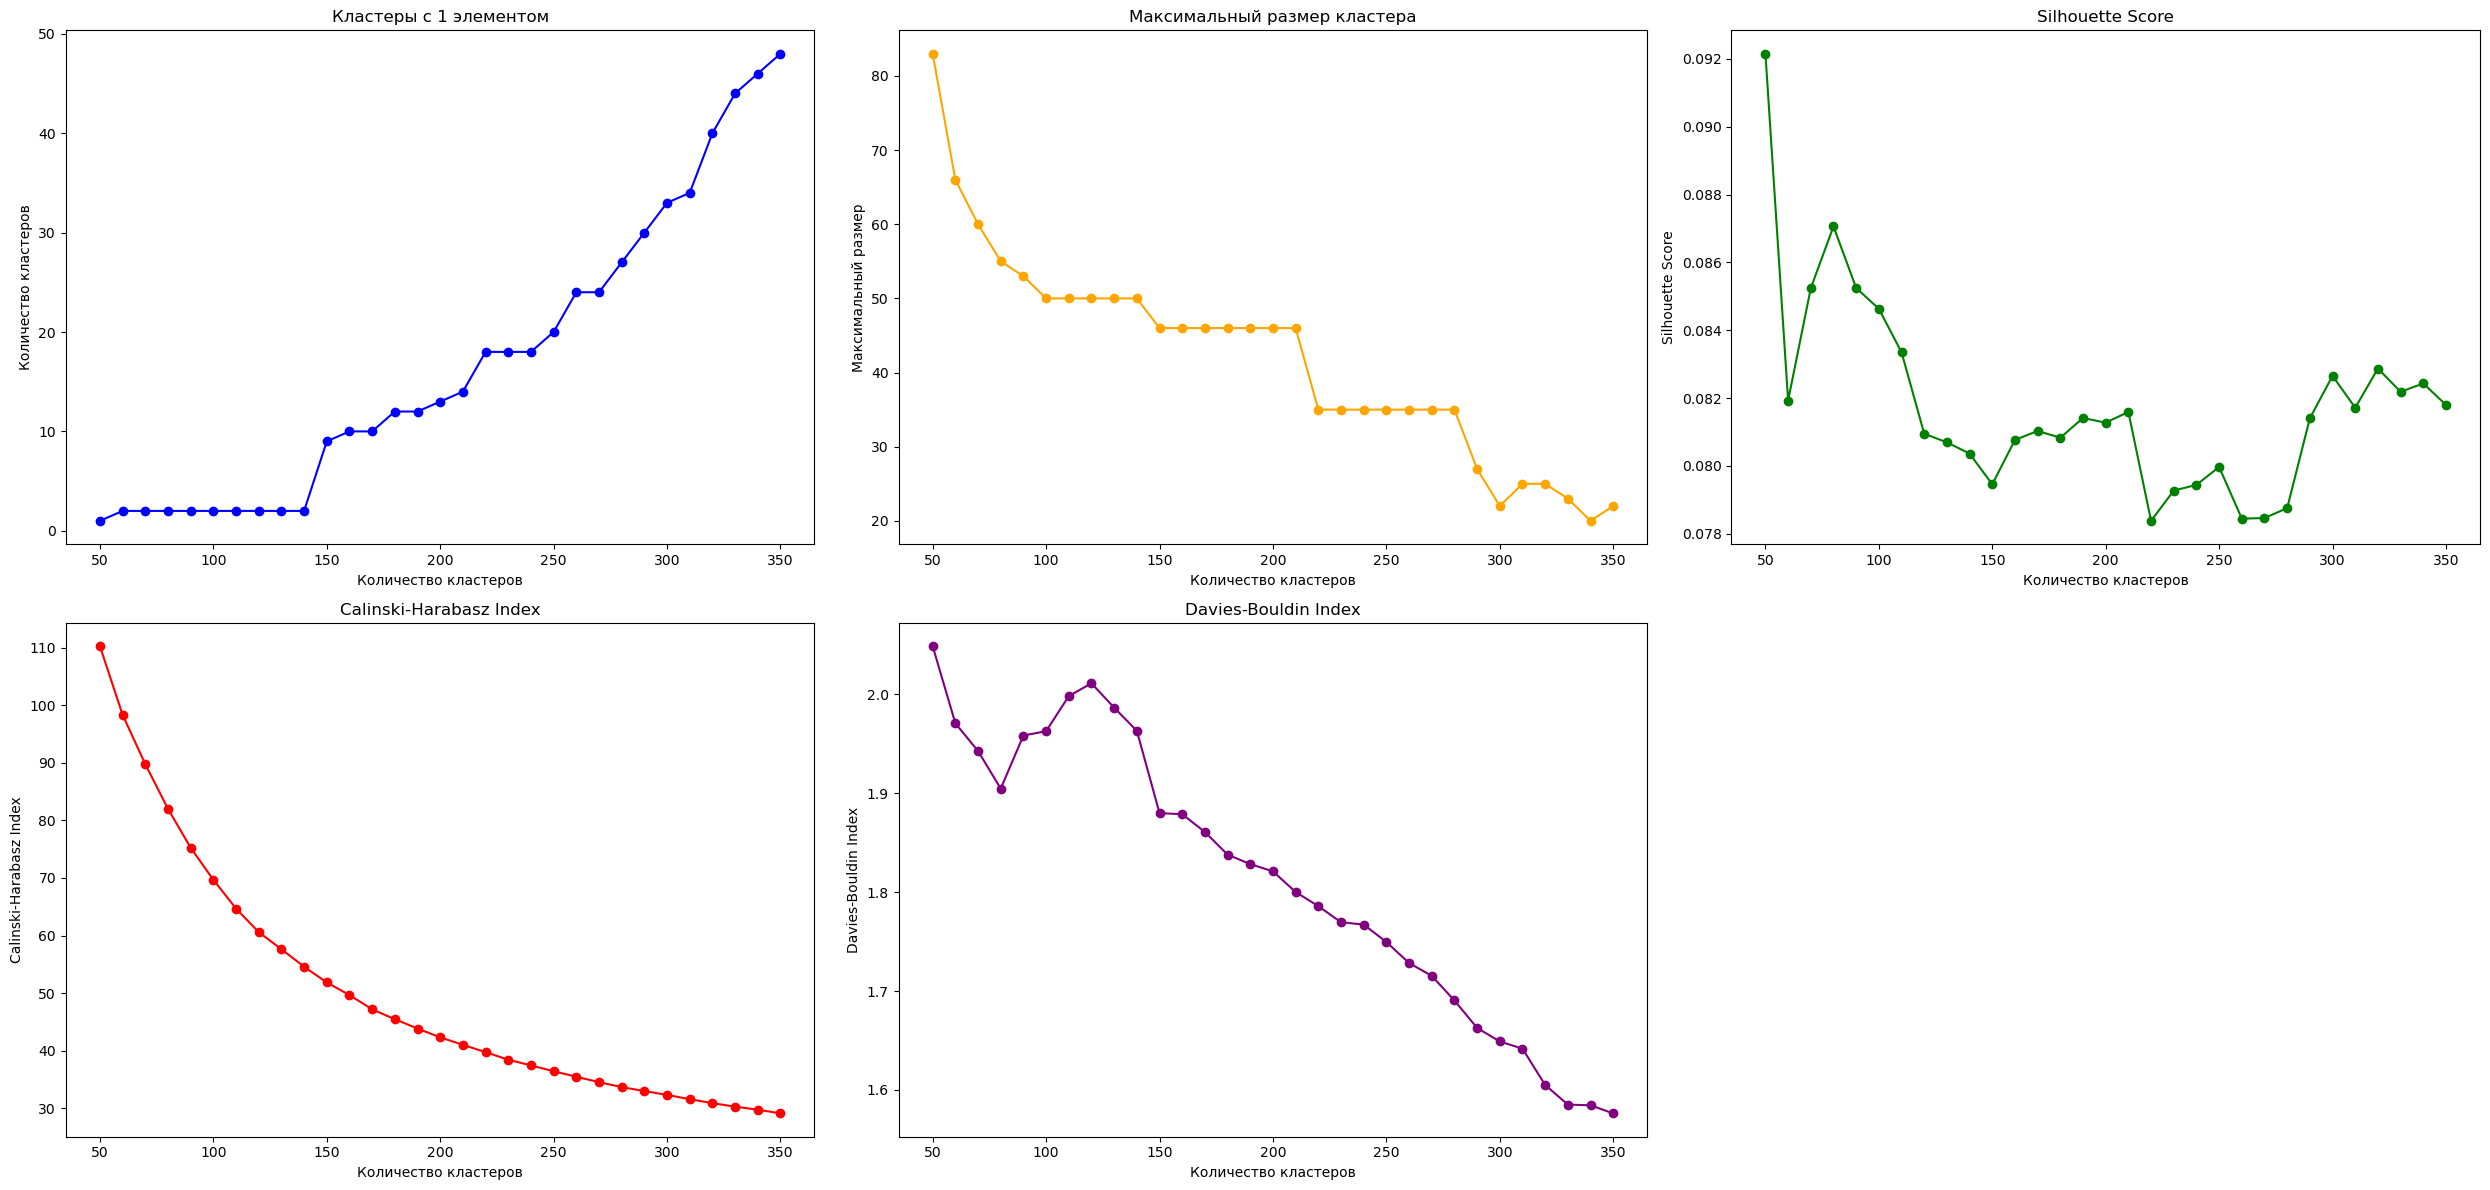

In [731]:
plt.figure(figsize=(25, 12))

plt.subplot(2, 3, 1)
plt.plot(n_clusters_range, single_item_clusters_list, marker='o', color='blue')
plt.title('Кластеры с 1 элементом')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 2)
plt.plot(n_clusters_range, max_cluster_size_list, marker='o', color='orange')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4)
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

После 310 кластеров идёт резкий рост кластеров с 1 элементом. При 300 кластерах хороший показатель максимального размера одного кластера - 20 статей. Метрика силуэта делает резкий скачок на 300 кластерах. Калински экспоненциально убывает, ничего интересного. У Davies-Bouldin резкое снижение после 310 кластеров.
Делаю вывод что оптимальное количество для этой модели (если надо максимально замельчить кластеры) - 300.

#### Вывод:
Векторизация + кластеризация справляется с тем чтобы найти похожие по содержанию статьи.

Но есть проблемы с оценкой качества. Так как данные не размечены, то я смотрю сама статьи, а физически посмотреть все кластеры невозможно. Есть метрики, можно смотреть по ним, но они показывают большую разницу на маленьком количестве кластеров, а т.к мне для задачи требуется много кластеров, там чаще всего линейная зависимость от количества кластеров.